## FontStyleGAN


### Setup

In [7]:
%load_ext autoreload
%autoreload 2

# Core libraries
import numpy as np
import torch

from util import show_grayscale_image
%matplotlib inline

USE_GPU = True

data_type = torch.FloatTensor

if USE_GPU and torch.cuda.is_available():
    data_type = torch.cuda.FloatTensor

print(torch.cuda.memory_allocated())

glyph_size = (16, 16)
glyphs_per_image = 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0


In [8]:
from data.font_dataset import FontDataset
from data.font_data_loader import FontDataLoader

dataset = FontDataset('./datasets/fonts/', glyph_size=glyph_size, glyphs_per_image=glyphs_per_image)
print(dataset[0].shape)

# Show what a normalized image looks like.
show_grayscale_image(dataset[0])

torch.Size([1, 16, 416])


torch.Size([1, 16, 16])


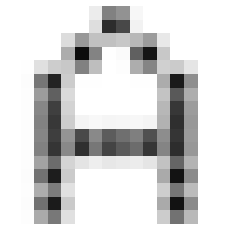

In [11]:
single_image = dataset[0][:,:,0:glyph_size[1]]
print(single_image.shape)

# Sample a specific image
show_grayscale_image(single_image)

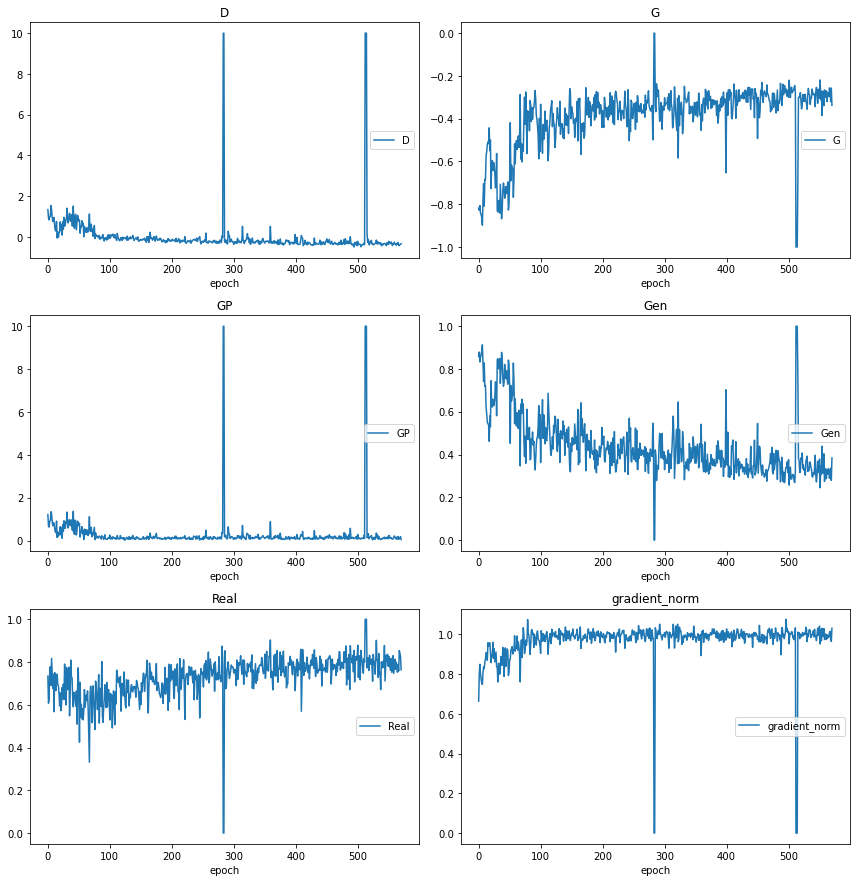

D
	D                	 (min:   -0.494, max:   10.000, cur:   -0.330)
G
	G                	 (min:   -1.000, max:   -0.000, cur:   -0.337)
GP
	GP               	 (min:    0.025, max:   10.000, cur:    0.049)
Gen
	Gen              	 (min:    0.000, max:    1.000, cur:    0.384)
Real
	Real             	 (min:    0.000, max:    1.000, cur:    0.763)
gradient_norm
	gradient_norm    	 (min:    0.000, max:    1.075, cur:    1.030)


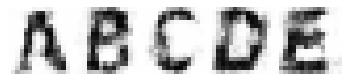

In [ ]:
from models.models import build_font_shape_generator, build_font_shape_discriminator, get_optimizer, initialize_weights
from train import train

print(torch.cuda.memory_allocated())

batch_size = 64
epoch_count = 1000
filter_dimension = 16

G = build_font_shape_generator(
    glyph_size=glyph_size,
    glyph_count=glyphs_per_image,
    dimension=filter_dimension
)

G_optimizer = get_optimizer(G)
G.apply(initialize_weights)

D = build_font_shape_discriminator(image_size=(glyph_size[0], glyph_size[1] * glyphs_per_image))

D_optimizer = get_optimizer(D)
D.apply(initialize_weights)

data_loader = FontDataLoader(dataset, batch_size=batch_size)

if USE_GPU and torch.cuda.is_available():
    G.cuda()
    D.cuda()
    
train(D, G, D_optimizer, G_optimizer, batch_size, epoch_count, data_loader, data_type, glyph_size, glyphs_per_image)

In [ ]:
JOSH: It seems that extra data, and less goal does not make this network better. We still get really grainy, awk


for data in data_loader:
    show_grayscale_image(data[0])
    print(D(data.type(data_type)))
    break
#     # For now, only use A
#     generated = G(data[0:1,:,:,0:64].type(data_type))
    
#     # Flatten the generated shape
#     generated_shape = generated.shape
#     generated = generated.reshape(generated_shape[0], generated_shape[1], 64, 2048)
#     print(generated.shape)
    
#     # Extract only letters A-Z (ignore blank space) (64 x 26 = 1664)
# #     generated = generated[:, :, :, 0:1664]
    
#     plt.imshow(transforms.Compose([
#         transforms.ToPILImage('L')
#     ])(generated[0].cpu()))
#     break
    